# Analysis for the experiments on the TCCP scenario

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from itertools import combinations

In [2]:
# Settings
fileName = "resultsTCCP.csv"
orderingStrategyPMedici = "IN_ORDER_SIZE_DESC"

In [3]:
# Load the file into a pandas dataframe
df = pd.read_csv(fileName, names=['Generator','ModelName','PercentageOfOldTsKept','TSSize','TSTime','Strength','Ordering',''], header=0, index_col=False)	
# Set Ordering to empty string where it is NaN
df['Ordering'].fillna('', inplace=True)

## Group all executions

In [4]:
# Group data in df by Generator, ModelName, PercentageOfOldTsKept, Strength, and Ordering. For the TSSize and TS time, take the mean
df = df.groupby(['Generator','ModelName','PercentageOfOldTsKept','Strength','Ordering']).agg({'TSSize':'mean', 'TSTime':'mean'}).reset_index()
# Remove from df all the lines where generator is pMEDICI or pMEDICI+ but Ordering is not equal to orderingStrategyPMedici
dfFiltered = df[~(df['Generator'].str.contains('pMEDICI')) | (df['Generator'].str.contains('pMEDICI') & (df['Ordering'] == orderingStrategyPMedici))]

In [5]:
# Count and print the number of timeouts per Generator
print(dfFiltered[dfFiltered['TSTime'] == -1].groupby(['ModelName','Generator', 'PercentageOfOldTsKept']).agg({'TSTime':'count'}).reset_index().groupby(['Generator', 'PercentageOfOldTsKept']).agg({'TSTime':'count'}))

                                 TSTime
Generator PercentageOfOldTsKept        
PICT      0                           7
          10                          8
          20                          8
          30                          8
          40                          8
          50                          8
          60                          8
          70                          8
          80                          8
          90                          8
          100                         8
pMEDICI   0                           5
pMEDICI+  0                           5
          10                          5
          20                          5
          30                          5
          40                          5
          50                          5
          60                          5
          70                          5
          80                          5
          90                          5
          100                         5


In [6]:
# Set all timeouts (TSTime = -1) to TSTime = 300001 and with Size = MAX Size
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSSize'] = 100000
dfFiltered.loc[dfFiltered['TSTime'] == -1, 'TSTime'] = 301000

# Remove all the rows corresponding to models for which at least one of the generators timed out
# dfFiltered = dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])]

## How does the execution time change depending on the PercentageOfTsKept?

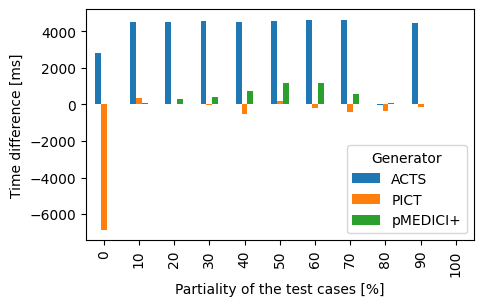

In [7]:
# Build a dataframe with for each model and PercentageOfOldTsKept the difference between the time required by the generator with PercentageOfOldTsKept = 100 and that with the selected PercentageOfOldTsKept
dfDiff = pd.DataFrame(columns=['ModelName','PercentageOfOldTsKept','TSTimeDiff', 'Generator'])
for generator in dfFiltered['Generator'].unique():
    if (generator == 'pMEDICI'):
        continue
    for modelName in dfFiltered['ModelName'].unique():
        for percentageOfOldTsKept in dfFiltered['PercentageOfOldTsKept'].unique():
            dfDiff.loc[len(dfDiff), dfDiff.columns] = {'ModelName':modelName, 
                                                    'PercentageOfOldTsKept':percentageOfOldTsKept, 
                                                    'Generator':generator,
                                                    'TSTimeDiff':dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == percentageOfOldTsKept) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSTime'].iloc[0] 
                                                                 - 
                                                                 dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == 100) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSTime'].iloc[0]
                                                    }

# Average the TSTimeDiff for each model over the different values of PercentageOfOldTsKept
dfDiff = dfDiff.groupby(['PercentageOfOldTsKept', 'Generator']).agg({'TSTimeDiff':'mean'}).reset_index()

# Barplot showing the distribution of the TSTimeDiff for each PercentageOfOldTsKept and for each Generator
ax = dfDiff.pivot(index='PercentageOfOldTsKept', columns='Generator', values='TSTimeDiff').plot.bar(figsize=(5,3))

# ax = dfDiff.sort_values(by = 'PercentageOfOldTsKept').plot.bar(x='PercentageOfOldTsKept', y='TSTimeDiff', figsize=(5,3))
ax.set_xlabel("Partiality of the test cases [%]")
ax.set_ylabel("Time difference [ms]")

plt.savefig("pictures/TCCP_TS_TimeDiff.pdf", bbox_inches='tight')

## How does the test suite size change depending on the PercentageOfTsKept?

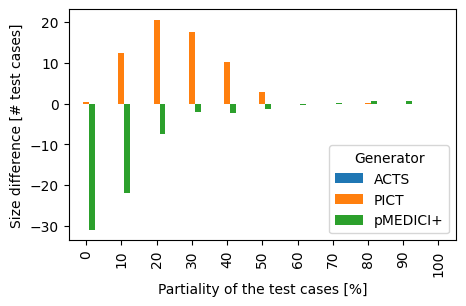

In [8]:
# Build a dataframe with for each model and PercentageOfOldTsKept the difference between the time required by the generator with PercentageOfOldTsKept = 100 and that with the selected PercentageOfOldTsKept
dfDiff = pd.DataFrame(columns=['ModelName','PercentageOfOldTsKept','TSSizeDiff', 'Generator'])
for generator in dfFiltered['Generator'].unique():
    if (generator == 'pMEDICI'):
        continue
    for modelName in dfFiltered[~dfFiltered['ModelName'].isin(dfFiltered[dfFiltered['TSTime'] == 301000]['ModelName'])]['ModelName'].unique():
        for percentageOfOldTsKept in dfFiltered['PercentageOfOldTsKept'].unique():
            dfDiff.loc[len(dfDiff), dfDiff.columns] = {'ModelName':modelName, 
                                                    'PercentageOfOldTsKept':percentageOfOldTsKept, 
                                                    'Generator':generator,
                                                    'TSSizeDiff':dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == percentageOfOldTsKept) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSSize'].iloc[0] 
                                                                 - 
                                                                 dfFiltered[(dfFiltered['ModelName'] == modelName) & (dfFiltered['PercentageOfOldTsKept'] == 100) 
                                                                            & (dfFiltered['Generator'] == generator)]['TSSize'].iloc[0]
                                                    }
        
# Average the TSTimeDiff for each model over the different values of PercentageOfOldTsKept
dfDiff = dfDiff.groupby(['PercentageOfOldTsKept', 'Generator']).agg({'TSSizeDiff':'mean'}).reset_index()

# Barplot showing the distribution of the TSTimeDiff for each PercentageOfOldTsKept and for each Generator
ax = dfDiff.pivot(index='PercentageOfOldTsKept', columns='Generator', values='TSSizeDiff').plot.bar(figsize=(5,3))

# ax = dfDiff.sort_values(by = 'PercentageOfOldTsKept').plot.bar(x='PercentageOfOldTsKept', y='TSTimeDiff', figsize=(5,3))
ax.set_xlabel("Partiality of the test cases [%]")
ax.set_ylabel("Size difference [# test cases]")

plt.savefig("pictures/TCCP_TS_SizeDiff.pdf", bbox_inches='tight')

## Timeouts analysis

In [9]:
# Count the number of timeouts for each tool and for each PercentageOfOldTsKept
dfTimeOuts = dfFiltered[dfFiltered['TSTime'] == 301000].groupby(['Generator','PercentageOfOldTsKept']).agg({'TSTime':'count'}).reset_index()
print (dfTimeOuts)

   Generator  PercentageOfOldTsKept  TSTime
0       PICT                      0       7
1       PICT                     10       8
2       PICT                     20       8
3       PICT                     30       8
4       PICT                     40       8
5       PICT                     50       8
6       PICT                     60       8
7       PICT                     70       8
8       PICT                     80       8
9       PICT                     90       8
10      PICT                    100       8
11   pMEDICI                      0       5
12  pMEDICI+                      0       5
13  pMEDICI+                     10       5
14  pMEDICI+                     20       5
15  pMEDICI+                     30       5
16  pMEDICI+                     40       5
17  pMEDICI+                     50       5
18  pMEDICI+                     60       5
19  pMEDICI+                     70       5
20  pMEDICI+                     80       5
21  pMEDICI+                    

## Summary data

In [10]:
# Print the average time and size for each Generator
dfSummary = dfFiltered[dfFiltered['PercentageOfOldTsKept'] == 80]
print(dfSummary.groupby(['Generator']).agg({'TSTime':'mean'}))
print(dfSummary[~dfSummary['ModelName'].isin(dfSummary[dfSummary['TSTime'] == 301000]['ModelName'])].groupby(['Generator']).agg({'TSSize':'mean'}))

              TSTime
Generator           
ACTS        5865.076
PICT       50769.116
pMEDICI+   31491.728
            TSSize
Generator         
ACTS        98.550
PICT       106.140
pMEDICI+   130.085


## Time analysis

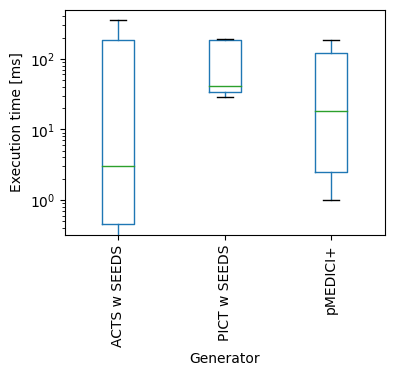

In [11]:
# Filter only data with PercentageOfOldTsKept = 80
dfExecutionTime = dfFiltered[dfFiltered['PercentageOfOldTsKept'] == 80]
# Extract the execution time of different generators
dfExecutionTime = dfExecutionTime[['Generator','TSTime']]
# Remove rows referred to pMEDICI
dfExecutionTime = dfExecutionTime[~ (dfExecutionTime['Generator'] ==  'pMEDICI')]

# Boxplot the execution time of different generators and remove the outliers
ax = dfExecutionTime.boxplot(by='Generator', showfliers=False, grid=False, rot=90)
ax.set_yscale('log')
ax.set_ylabel('Execution time [ms]')
ax.set_xticklabels(['ACTS w SEEDS', 'PICT w SEEDS', 'pMEDICI+'])
ax.set_xlabel('Generator')
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(4, 3)
# Export the figure in PDF
plt.savefig("pictures/TCCP_TS_Time.pdf", bbox_inches='tight')

In [12]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfExecutionTime['Generator'].unique()
generators = generators[generators != 'pMEDICI']
for generator1, generator2 in combinations(generators, 2):
    print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfExecutionTime[dfExecutionTime['Generator'] == generator1]['TSTime'], dfExecutionTime[dfExecutionTime['Generator'] == generator2]['TSTime']))

ACTS VS PICT:
 WilcoxonResult(statistic=154.0, pvalue=5.215646012857178e-07)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=419.5, pvalue=0.03453081197041463)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=389.5, pvalue=0.06479956602784713)


c:\Users\Andrea_PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Size analysis

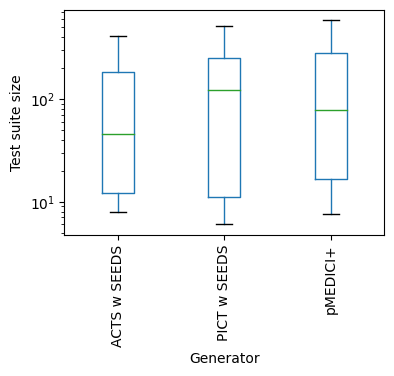

In [13]:
# Filter only data with PercentageOfOldTsKept = 80
dfExecutionSize = dfFiltered[dfFiltered['PercentageOfOldTsKept'] == 80]
# Extract the execution time of different generators
dfExecutionSize = dfExecutionSize[['Generator','TSSize']]
# Remove rows referred to pMEDICI
dfExecutionSize = dfExecutionSize[~ (dfExecutionSize['Generator'] ==  'pMEDICI')]

# Boxplot the execution time of different generators and remove the outliers
ax = dfExecutionSize.boxplot(by='Generator', showfliers=False, grid=False, rot=90)
ax.set_yscale('log')
ax.set_ylabel('Test suite size')
ax.set_xlabel('Generator')
ax.set_xticklabels(['ACTS w SEEDS', 'PICT w SEEDS', 'pMEDICI+'])
ax.set_title('')
plt.suptitle('')
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(4, 3)
# Export the figure in PDF
plt.savefig("pictures/TCCP_TS_Size.pdf", bbox_inches='tight')

In [14]:
# Execute a Wilcoxon Signed-Rank test among each couple of Generators investigating the TSTime
generators = dfExecutionTime['Generator'].unique()
generators = generators[generators != 'pMEDICI']
for generator1, generator2 in combinations(generators, 2):
    print(generator1 + " VS " + generator2 + ":\n", wilcoxon(dfExecutionSize[dfExecutionSize['Generator'] == generator1]['TSSize'], dfExecutionSize[dfExecutionSize['Generator'] == generator2]['TSSize']))

ACTS VS PICT:
 WilcoxonResult(statistic=240.5, pvalue=0.0029220671251392926)
ACTS VS pMEDICI+:
 WilcoxonResult(statistic=11.0, pvalue=3.2559629390999058e-09)
PICT VS pMEDICI+:
 WilcoxonResult(statistic=291.0, pvalue=0.0064122262805496825)


c:\Users\Andrea_PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
